In [102]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from statsmodels.formula.api import ols

import acquire
import prepare
import model

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [255]:
# acquire.pull_csv_file()
df = acquire.read_telco_data()
df.shape

(7043, 24)

In [230]:
df = prepare.prep_data(df)
df.head(1)

,internet_service_type_id,payment_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,payment_type,internet_service_type,tenure_years,is_churn
0,1,2,1,0003-MKNFE,0,0,0,0,9,1,...,1,0,59.9,542.4,0,Month-to-month,Mailed check,DSL,0,0


In [231]:
df.is_churn.mean()

0.2653698707936959

In [232]:
train, validate, test = prepare.split_data(df)

In [233]:
train.is_churn.mean()

0.2672189349112426

In [234]:
train.groupby('contract_type_id').is_churn.mean()

contract_type_id
1    0.426251
2    0.114679
3    0.031558
Name: is_churn, dtype: float64

In [235]:
train.is_churn.mean()

0.2672189349112426

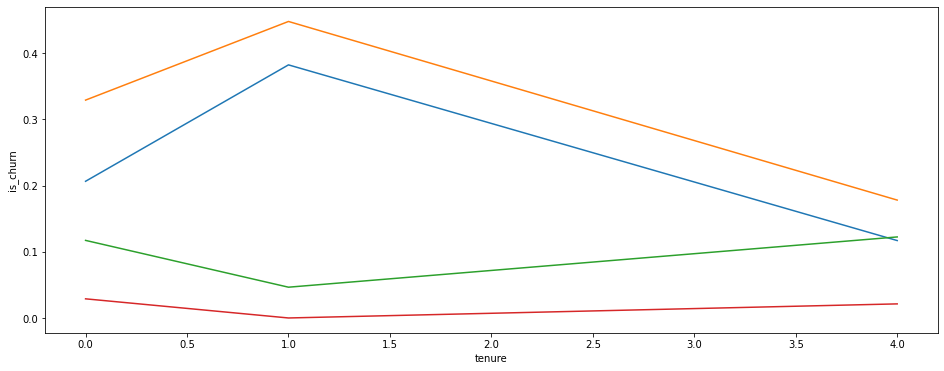

In [238]:
x = train.tenure // 6
y = train.groupby(train.tenure // 6).is_churn.mean()
y1 = train[train.contract_type == 'Month-to-month'].groupby(train.tenure // 6).is_churn.mean()
y2 = train[train.contract_type == 'One year'].groupby(train.tenure // 6).is_churn.mean()
y3 = train[train.contract_type == 'Two year'].groupby(train.tenure // 6).is_churn.mean()

plt.figure(figsize=(16,6))
plt.legend
sns.lineplot(x, y, data=train, ci=None)
sns.lineplot(x, y1, data=train, ci=None)
sns.lineplot(x, y2, data=train, ci=None)
sns.lineplot(x, y3, data=train, ci=None)

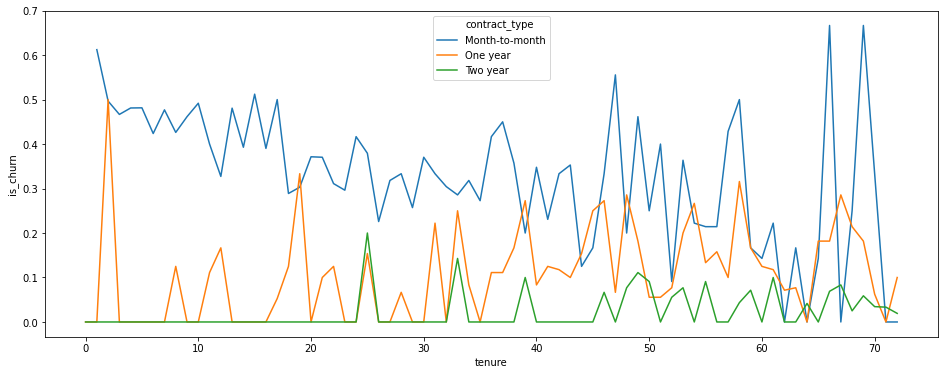

In [239]:
plt.figure(figsize=(16,6))
sns.lineplot('tenure', 'is_churn', hue='contract_type', data=train, ci=None)

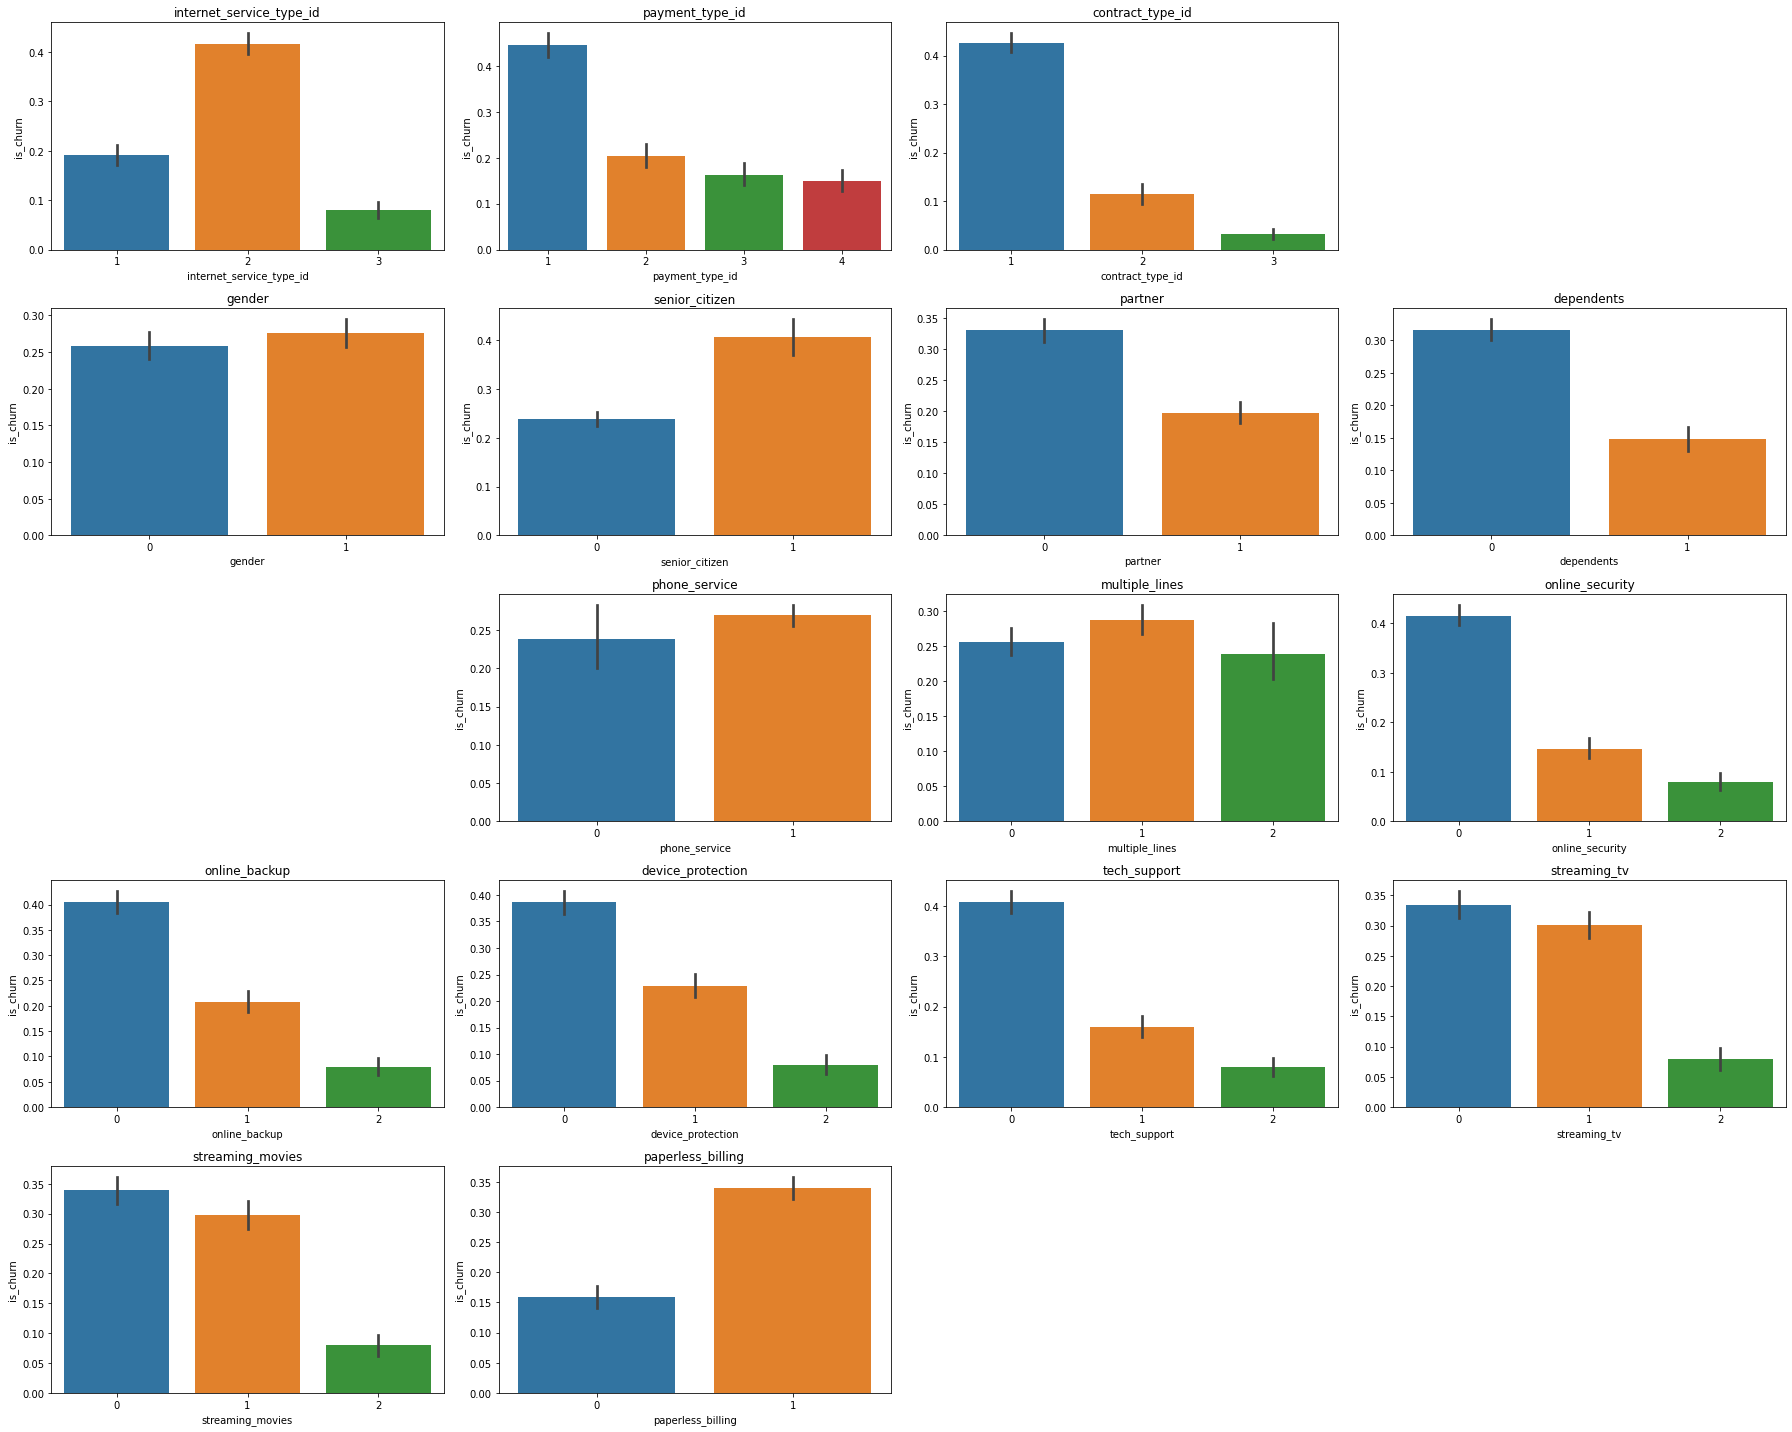

In [172]:
f = plt.figure(figsize=(25,20))
for i in range(0,20):
    if len(train.groupby(train.iloc[:,i])) < 5:
        f.add_subplot(5,4, i+1)
        sns.barplot(data=train, y="is_churn", x=train.iloc[:,i])
        plt.title(train.columns[i])
plt.tight_layout()
plt.show()

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Legend does not support <matplotlib.axes._subplots.AxesSubplot object at 0x125bb7890> instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  


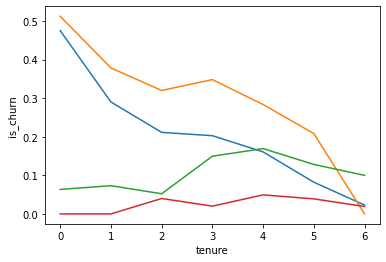

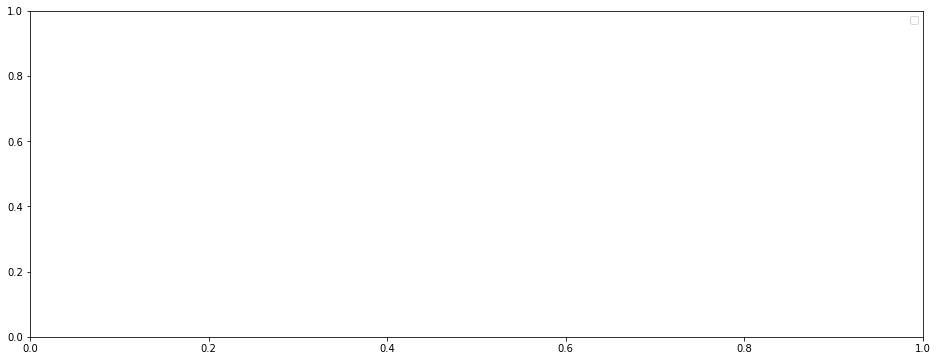

In [253]:
x = train.groupby(train.tenure // 12).tenure.sum().index
y = train.groupby(train.tenure // 12).is_churn.mean()
y1 = train[train.contract_type == 'Month-to-month'].groupby(train.tenure // 12).is_churn.mean()
y2 = train[train.contract_type == 'One year'].groupby(train.tenure // 12).is_churn.mean()
y3 = train[train.contract_type == 'Two year'].groupby(train.tenure // 12).is_churn.mean()

line1 = sns.lineplot(x, y, data=train, ci=None, legend='full')
line2 = sns.lineplot(x, y1, data=train, ci=None)
line3 = sns.lineplot(x, y2, data=train, ci=None)
line4 = sns.lineplot(x, y3, data=train, ci=None)


plt.figure(figsize=(16,6))
plt.legend((line1, line2, line3, line4), ('Overall', 'Month-to-month', 'One year', 'Two years'))

line1
line2
line3
line4

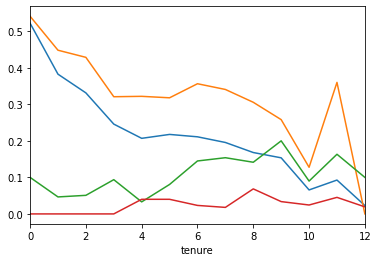

In [174]:
train.groupby(train.tenure // 6).is_churn.mean().plot()
train[train.contract_type == 'Month-to-month'].groupby(train.tenure // 6).is_churn.mean().plot()
train[train.contract_type == 'One year'].groupby(train.tenure // 6).is_churn.mean().plot()
train[train.contract_type == 'Two year'].groupby(train.tenure // 6).is_churn.mean().plot()



In [175]:
train.groupby(train.tenure // 6).tenure.sum().index

Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], dtype='int64', name='tenure')

In [176]:
train['tenure_grouped'] = train.tenure // 6

In [177]:
train.groupby('tenure_grouped').tenure.sum().index

Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], dtype='int64', name='tenure_grouped')

In [178]:
train.tenure_grouped

440      1
67       0
600      0
4883    11
1258    10
        ..
1794     9
817      0
901      0
1987     9
6958     2
Name: tenure_grouped, Length: 4225, dtype: int64

## Is there a price threshold for specific services where the likelihood of churn increases once price for those services goes past that point? If so, what is that point for what service(s)?

In [179]:
train.is_churn.value_counts()

0    3096
1    1129
Name: is_churn, dtype: int64

In [180]:
# x = train.groupby((train.monthly_charges // 10)*10).is_churn.mean().index
# y = train.groupby((train.monthly_charges//10)*10).is_churn.mean().plot()

# sns.lineplot(x, y)
train.head()

,internet_service_type_id,payment_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,paperless_billing,monthly_charges,total_charges,churn,contract_type,payment_type,internet_service_type,tenure_years,is_churn,tenure_grouped
440,1,4,1,3701-SFMUH,0,0,1,1,7,1,...,0,69.70,516.15,0,Month-to-month,Credit card (automatic),DSL,0,0,1
67,1,1,1,0674-EYYZV,1,0,0,0,1,1,...,1,54.65,54.65,0,Month-to-month,Electronic check,DSL,0,0,0
600,1,4,1,4918-QLLIW,0,0,0,0,3,1,...,0,53.40,188.70,1,Month-to-month,Credit card (automatic),DSL,0,1,0
4883,2,4,2,6097-EQISJ,1,0,1,1,66,1,...,1,102.45,6615.15,1,One year,Credit card (automatic),Fiber optic,5,1,11
1258,1,3,2,0654-PQKDW,1,0,1,1,62,1,...,1,70.75,4263.45,0,One year,Bank transfer (automatic),DSL,5,0,10


In [181]:
train.internet_service_type.value_counts(), train.internet_service_type_id.value_counts()

(Fiber optic    1866
 DSL            1454
 None            905
 Name: internet_service_type, dtype: int64, 2    1866
 1    1454
 3     905
 Name: internet_service_type_id, dtype: int64)

In [182]:
# # male_mask = train.gender == 0
# # female_mask = train.gender == 1
churn = pd.DataFrame(train.groupby((train.monthly_charges // 5)*5).is_churn.mean())
# # churn_output['is_male'] = train[male_mask].groupby((train.monthly_charges // 5)*5).is_churn.mean()
# # churn_output["is_female"] = train[female_mask].groupby((train.monthly_charges // 5)*5).is_churn.mean()
# churn["paperless"] = train[train.paperless_billing == 1].groupby((train.monthly_charges // 5)*5).is_churn.mean()
# churn["mailed_bill"] = train[train.paperless_billing == 0].groupby((train.monthly_charges // 5)*5).is_churn.mean()
# churn["fiber_optic"] = train[train.internet_service_type_id == 2].groupby((train.monthly_charges // 5)*5).is_churn.mean()
# churn["dsl"] = train[train.internet_service_type_id == 1].groupby((train.monthly_charges // 5)*5).is_churn.mean()
# churn["no_internet"] = train[train.internet_service_type_id == 3].groupby((train.monthly_charges // 5)*5).is_churn.mean()

churn.head()

,is_churn
monthly_charges,
15.0,0.095890
20.0,0.101099
25.0,0.121212
30.0,0.339623
35.0,0.237288


In [157]:
def subset_churn_data(column_list):
    df = pd.DataFrame(train.groupby((train.monthly_charges // 5)*5).is_churn.mean())
    for c in column_list:
        subset_list = train[c].value_counts().index
        for i in subset_list:
            df[i] = train[train[c] == i].groupby((train.monthly_charges // 5)*5).is_churn.mean()
    return df
    

In [158]:
column_list = ['internet_service_type', 'payment_type', 'contract_type', 'dependents']
churn = subset_churn_data(column_list)
churn.head(1)

,is_churn,Fiber optic,DSL,None,Electronic check,Mailed check,Credit card (automatic),Bank transfer (automatic),Month-to-month,Two year,One year,0,1
monthly_charges,,,,,,,,,,,,,
15.0,0.09589,NaN,NaN,0.09589,0.228571,0.107143,0.026316,0.068966,0.195946,0.01626,0.042553,0.102222,0.085714


In [159]:
def make_churn_bar_plots(df):
    f = plt.figure(figsize=(16,100))
    x = churn.shape[1]
    for i in range(0, x):
        f.add_subplot(20, 1, i+1)
        sns.barplot(data=churn, y=churn.iloc[:,i], x=churn.index)
        plt.title(churn.columns[i])
    plt.tight_layout()
    plt.show() 


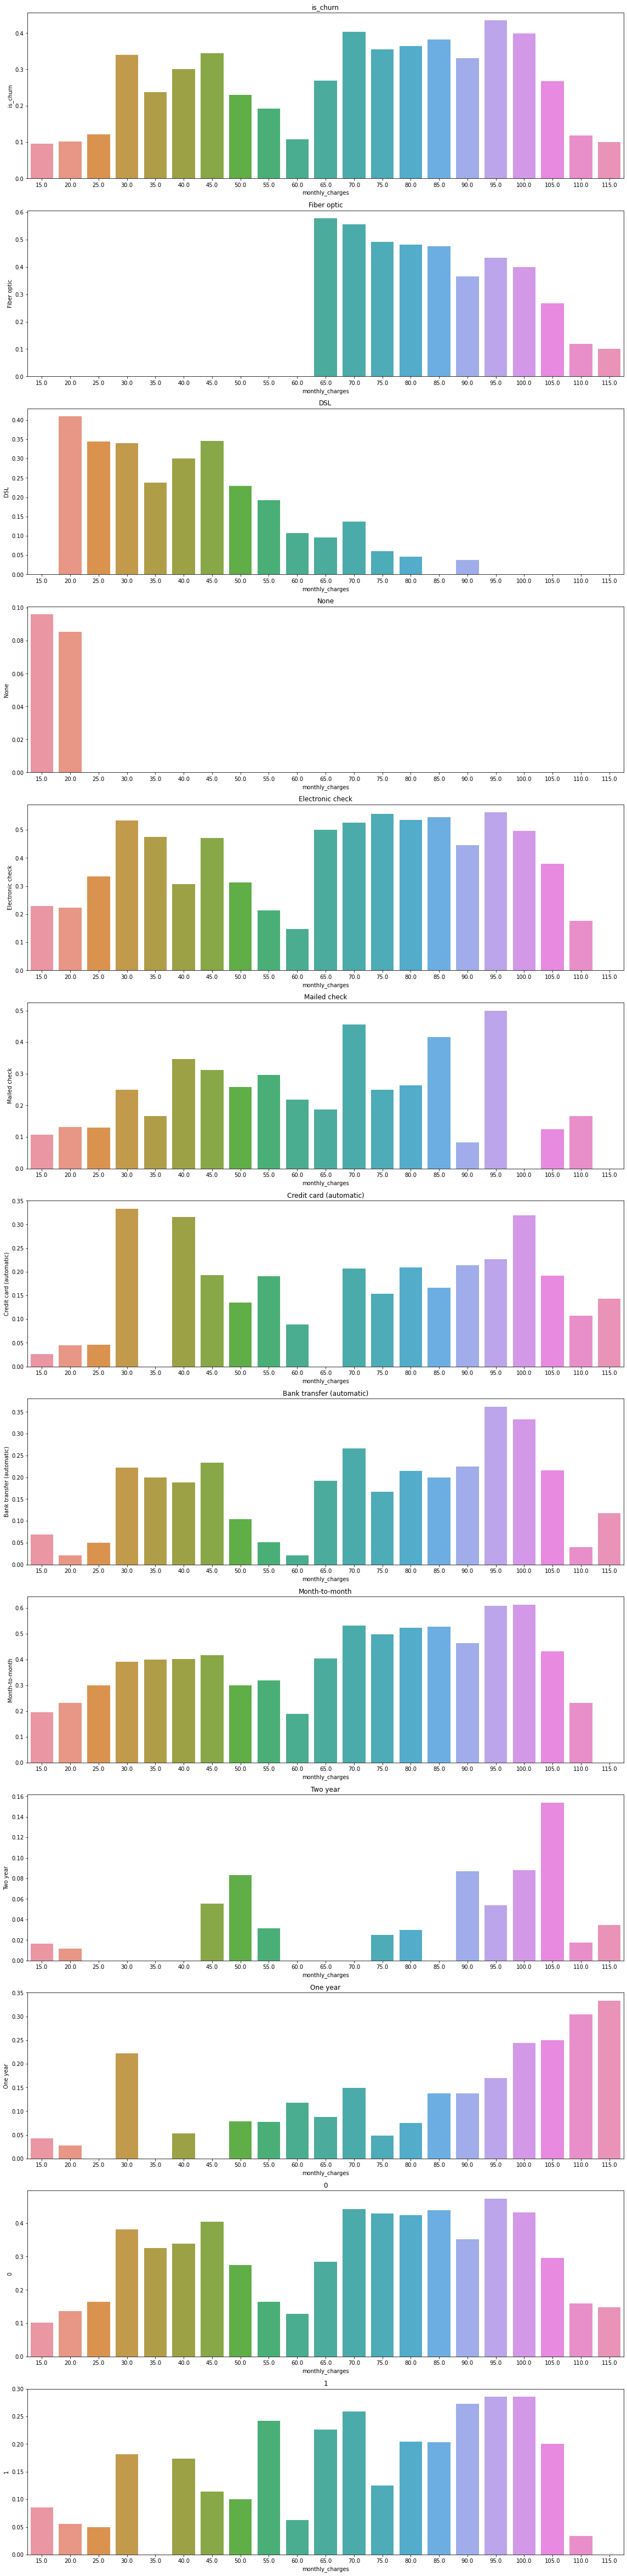

In [160]:
make_churn_bar_plots(churn)

In [161]:
# subset_churn_data('internet_service_type').index[0]

AttributeError: 'DataFrame' object has no attribute 'fiber_optic'

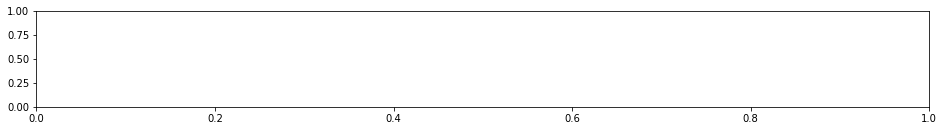

In [162]:
plt.figure(figsize=(16,6))

plt.subplot(3,1,1)
sns.barplot(x, churn.fiber_optic)
plt.subplot(3,1,2)
sns.barplot(x, churn.dsl)
plt.subplot(3,1,3)
sns.barplot(x, churn.no_internet)

In [ ]:
# f = plt.figure(figsize=(25,20))

# for i in range(0,21):
#     if len(train.groupby(train.iloc[:,i+3])) < 5:
#         f.add_subplot(5,5, i+1)
#         sns.lineplot(data=train, y="is_churn", x=train.iloc[:,i+3])
#         plt.title(train.columns[i+3])
# plt.tight_layout()
# plt.show()

In [ ]:
# Does the monthly charges of people with online_security, tech_support, device_protection and online_backup different than the rest?
group = ["online_security", "online_backup", "tech_support", "device_protection"]
pd.pivot_table(train, values="monthly_charges", index=group, columns="churn", aggfunc="mean").reset_index()

In [ ]:
# Does the monthly charges of people with online_security, tech_support, device_protection and online_backup different than the rest?
group = ["online_security", "online_backup", "tech_support", "device_protection"]
pd.pivot_table(train, values="monthly_charges", index=group, columns="churn", aggfunc="count").reset_index()

In [ ]:
train.head()

In [ ]:
pd.crosstab(columns=train.is_churn, index=([train.contract_type, train.internet_service_type]), values=train.is_churn, aggfunc='mean')

In [ ]:
true_mask = train.is_churn == True
false_mask = train.is_churn == False

true_mask

In [ ]:
X = train[['tenure']]
y = train[['monthly_charges']]

lm_churn = LinearRegression().fit(X=X, y=y)
lm_no_churn =

In [183]:
train.churn = train.churn.replace({1:"yes", 0: "no"})

In [ ]:
train['combine_churn_contract_type'] = train.churn + " " + train.contract_type

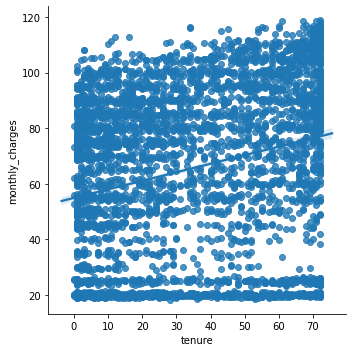

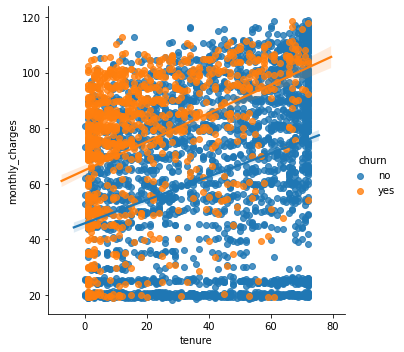

In [184]:
sns.lmplot(data=train, x='tenure', y='monthly_charges')
sns.lmplot(data=train, x='tenure', y='monthly_charges', hue = 'churn')

<Figure size 1152x1152 with 0 Axes>

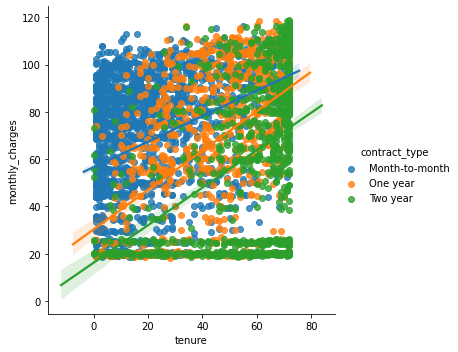

<Figure size 1152x1152 with 0 Axes>

In [185]:
sns.lmplot(data=train, x='tenure', y='monthly_charges', hue = 'contract_type')
plt.figure(figsize=(16,16))

In [42]:
internet_churn = train[train.internet_service_type != "None"].is_churn.mean()
phone_churn = train[train.internet_service_type == "None"].is_churn.mean()
internet_count = train[train.internet_service_type != "None"].is_churn.count()
phone_count = train[train.internet_service_type == "None"].is_churn.count()
internet_m_value = train[train.internet_service_type != "None"].monthly_charges.mean()
phone_m_value = train[train.internet_service_type == "None"].monthly_charges.mean()
internet_tenure = train[train.internet_service_type != "None"].tenure.mean()

print(internet_churn, phone_churn)
print(internet_count, phone_count)
print(internet_m_value, phone_m_value)


0.3183734939759036 0.07955801104972375
3320 905
76.59194277108425 21.12955801104972


In [186]:
telco = acquire.read_telco_data()
telco.shape

(7043, 24)

In [187]:
telco = telco[telco.internet_service_type != "None"]
telco.shape

(5517, 24)

In [188]:
train, validate, test = prepare.split_data(telco)

In [189]:
train, validate, test = prepare.split_data(telco)
y_train = train.is_churn
y_validate = validate.is_churn
y_test = test.is_churn
train.shape

AttributeError: 'DataFrame' object has no attribute 'is_churn'

In [66]:
evaluation = pd.DataFrame({"actual": y_train})
evaluation["baseline"] = 0

In [67]:
labels = sorted(y_train.unique())
matrix = pd.DataFrame(confusion_matrix(evaluation.actual, evaluation.baseline), index = labels, columns = labels)
matrix

,False,True
False,2272,0
True,1037,0


In [68]:
X_train, X_validate, X_test = prepare.full_prep_for_modeling(telco)

In [69]:
X_train.shape

(3309, 15)

In [70]:
logict, y_pred = model.run_lg(X_train, y_train)
evaluation["logistic_regression_1"] = y_pred

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [72]:
accuracy_score, matrix, report = model.accuracy_report(logict, y_pred, y_train)

In [73]:
print(accuracy_score)
print(matrix)
report

Accuracy on training set: 0.78
       False  True 
False   1967    305
True     421    616


,False,True,accuracy,macro avg,weighted avg
precision,0.823702,0.668838,0.780598,0.746270,0.775169
recall,0.865757,0.594021,0.780598,0.729889,0.780598
f1-score,0.844206,0.629213,0.780598,0.736710,0.776830
support,2272.000000,1037.000000,0.780598,3309.000000,3309.000000


In [74]:
coef = logict.coef_[0]
# We want to check that the coef array has the same number of items as there are features in our X_train dataframe.
assert(len(coef) == X_train.shape[1])
coef = logict.coef_[0]
columns = X_train.columns
df = pd.DataFrame({"feature": columns,
                   "feature_importance": coef,
                  })

Text(0.5, 1.0, 'What are the most influencial features?')

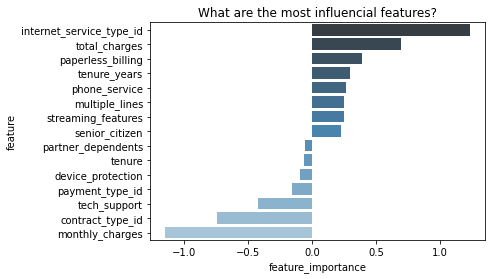

In [75]:
df = df.sort_values(by="feature_importance", ascending=False)
sns.barplot(data=df, x="feature_importance", y="feature", palette="Blues_d")
plt.title("What are the most influencial features?")

In [ ]:
telco = acquire.read_telco_data()

In [79]:
telco = telco[telco.internet_service_type != "None"]
telco.shape

(5517, 26)

In [80]:
X_train, X_validate, X_test = prepare.full_prep_for_modeling(telco)

In [81]:
for i in range(1,26):
    clf, y_pred = model.run_clf(X_train, y_train, i)
    print(f'max_depth = {i}, train_accuracy = {clf.score(X_train, y_train):.2%}, diff_accuracy = {(clf.score(X_train, y_train) - clf.score(X_validate, y_validate))/clf.score(X_validate, y_validate):.0%}')

max_depth = 1, train_accuracy = 68.66%, diff_accuracy = -2%
max_depth = 2, train_accuracy = 73.56%, diff_accuracy = -0%
max_depth = 3, train_accuracy = 75.79%, diff_accuracy = -1%
max_depth = 4, train_accuracy = 76.49%, diff_accuracy = 1%
max_depth = 5, train_accuracy = 78.21%, diff_accuracy = 4%
max_depth = 6, train_accuracy = 78.94%, diff_accuracy = 4%
max_depth = 7, train_accuracy = 79.93%, diff_accuracy = 6%
max_depth = 8, train_accuracy = 81.11%, diff_accuracy = 9%
max_depth = 9, train_accuracy = 83.35%, diff_accuracy = 14%
max_depth = 10, train_accuracy = 85.16%, diff_accuracy = 18%
max_depth = 11, train_accuracy = 87.46%, diff_accuracy = 20%
max_depth = 12, train_accuracy = 89.51%, diff_accuracy = 26%
max_depth = 13, train_accuracy = 91.33%, diff_accuracy = 28%
max_depth = 14, train_accuracy = 92.69%, diff_accuracy = 30%
max_depth = 15, train_accuracy = 94.59%, diff_accuracy = 33%
max_depth = 16, train_accuracy = 95.89%, diff_accuracy = 36%
max_depth = 17, train_accuracy = 96.98

In [82]:
clf, y_pred = model.run_clf(X_train, y_train, 6)
evaluation["decision_tree_model"] = y_pred

In [83]:
accuracy_score, matrix, report = model.accuracy_report(clf, y_pred, y_train)

In [84]:
print(accuracy_score)
print(matrix)
report

Accuracy on training set: 0.79
       False  True 
False   2003    269
True     428    609


,False,True,accuracy,macro avg,weighted avg
precision,0.823941,0.693622,0.789362,0.758781,0.783100
recall,0.881602,0.587271,0.789362,0.734437,0.789362
f1-score,0.851797,0.636031,0.789362,0.743914,0.784178
support,2272.000000,1037.000000,0.789362,3309.000000,3309.000000


In [85]:
telco = acquire.read_telco_data()
telco = telco[telco.internet_service_type != "None"]
X_train, X_validate, X_test = prepare.full_prep_for_modeling_encoded(telco)

In [86]:
# We want to find what hyperameter will gives us the best result, so we look at the scores for different parameters. 
for i in range(1,20):
    rf, y_pred = model.run_rf(X_train, y_train, 1, i)
    print(f'max_depth = {i}, train_accuracy = {rf.score(X_train, y_train):.2%}, diff_accuracy = {(rf.score(X_train, y_train) - rf.score(X_validate, y_validate))/rf.score(X_validate, y_validate):.0%}')

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


max_depth = 1, train_accuracy = 68.66%, diff_accuracy = -2%
max_depth = 2, train_accuracy = 75.22%, diff_accuracy = -2%
max_depth = 3, train_accuracy = 76.25%, diff_accuracy = -1%


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


max_depth = 4, train_accuracy = 77.18%, diff_accuracy = 0%
max_depth = 5, train_accuracy = 77.79%, diff_accuracy = 2%
max_depth = 6, train_accuracy = 79.36%, diff_accuracy = 3%


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


max_depth = 7, train_accuracy = 80.42%, diff_accuracy = 5%
max_depth = 8, train_accuracy = 82.90%, diff_accuracy = 8%


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


max_depth = 9, train_accuracy = 85.07%, diff_accuracy = 12%
max_depth = 10, train_accuracy = 87.10%, diff_accuracy = 14%
max_depth = 11, train_accuracy = 90.48%, diff_accuracy = 19%


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


max_depth = 12, train_accuracy = 93.68%, diff_accuracy = 24%
max_depth = 13, train_accuracy = 95.16%, diff_accuracy = 26%


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


max_depth = 14, train_accuracy = 95.92%, diff_accuracy = 28%


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


max_depth = 15, train_accuracy = 96.89%, diff_accuracy = 29%
max_depth = 16, train_accuracy = 97.46%, diff_accuracy = 27%


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


max_depth = 17, train_accuracy = 97.40%, diff_accuracy = 30%
max_depth = 18, train_accuracy = 97.79%, diff_accuracy = 30%


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


max_depth = 19, train_accuracy = 97.58%, diff_accuracy = 29%


In [123]:
rf, y_pred = model.run_rf(X_train, y_train, 1, 6)
evaluation["rf_2"] = y_pred

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


ValueError: Length of values does not match length of index

In [88]:
accuracy_score, matrix, report = model.accuracy_report(rf, y_pred, y_train)

print(accuracy_score)
print(matrix)
report

Accuracy on training set: 0.83
       False  True 
False   2045    227
True     339    698


,False,True,accuracy,macro avg,weighted avg
precision,0.857802,0.754595,0.828951,0.806198,0.825458
recall,0.900088,0.673095,0.828951,0.786592,0.828951
f1-score,0.878436,0.711519,0.828951,0.794978,0.826127
support,2272.000000,1037.000000,0.828951,3309.000000,3309.000000


In [89]:
y_pred = rf.predict(X_validate)
accuracy_score, matrix, report = model.accuracy_report(rf, y_pred, y_validate)

print(accuracy_score)
print(matrix)
report

Accuracy on training set: 0.77
       False  True 
False    657    114
True     143    190


,False,True,accuracy,macro avg,weighted avg
precision,0.82125,0.625000,0.76721,0.723125,0.762055
recall,0.85214,0.570571,0.76721,0.711355,0.767210
f1-score,0.83641,0.596546,0.76721,0.716478,0.764060
support,771.00000,333.000000,0.76721,1104.000000,1104.000000


In [126]:
telco = acquire.read_telco_data()
telco = telco[telco.contract_type_id != 3]
X_train, X_validate, X_test = prepare.full_prep_for_modeling_encoded(telco)

In [127]:
train, validate, test = prepare.split_data(telco)
y_train = train.is_churn
y_validate = validate.is_churn
y_test = test.is_churn
train.shape

(3208, 26)

In [128]:
# We want to find what hyperameter will gives us the best result, so we look at the scores for different parameters. 
for i in range(1,20):
    rf, y_pred = model.run_rf(X_train, y_train, 1, i)
    print(f'max_depth = {i}, train_accuracy = {rf.score(X_train, y_train):.2%}, diff_accuracy = {(rf.score(X_train, y_train) - rf.score(X_validate, y_validate))/rf.score(X_validate, y_validate):.0%}')

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


max_depth = 1, train_accuracy = 66.15%, diff_accuracy = 2%
max_depth = 2, train_accuracy = 73.57%, diff_accuracy = 1%
max_depth = 3, train_accuracy = 73.53%, diff_accuracy = -2%


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


max_depth = 4, train_accuracy = 74.91%, diff_accuracy = 1%
max_depth = 5, train_accuracy = 75.06%, diff_accuracy = 1%
max_depth = 6, train_accuracy = 76.50%, diff_accuracy = 1%


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


max_depth = 7, train_accuracy = 78.15%, diff_accuracy = 5%
max_depth = 8, train_accuracy = 80.30%, diff_accuracy = 7%


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


max_depth = 9, train_accuracy = 83.54%, diff_accuracy = 11%
max_depth = 10, train_accuracy = 86.75%, diff_accuracy = 16%


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


max_depth = 11, train_accuracy = 90.24%, diff_accuracy = 22%
max_depth = 12, train_accuracy = 92.52%, diff_accuracy = 28%


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


max_depth = 13, train_accuracy = 94.30%, diff_accuracy = 31%
max_depth = 14, train_accuracy = 96.10%, diff_accuracy = 33%


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


max_depth = 15, train_accuracy = 96.85%, diff_accuracy = 31%
max_depth = 16, train_accuracy = 97.29%, diff_accuracy = 34%


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


max_depth = 17, train_accuracy = 97.51%, diff_accuracy = 34%
max_depth = 18, train_accuracy = 97.76%, diff_accuracy = 35%
max_depth = 19, train_accuracy = 97.54%, diff_accuracy = 33%


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [133]:
rf, y_pred = model.run_rf(X_train, y_train, 1, 6)
# evaluation["rf_2"] = y_pred

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [134]:
accuracy_score, matrix, report = model.accuracy_report(rf, y_pred, y_train)

print(accuracy_score)
print(matrix)
report

Accuracy on training set: 0.76
       False  True 
False   1885    237
True     517    569


,False,True,accuracy,macro avg,weighted avg
precision,0.784763,0.705955,0.764963,0.745359,0.758084
recall,0.888313,0.523941,0.764963,0.706127,0.764963
f1-score,0.833333,0.601480,0.764963,0.717407,0.754844
support,2122.000000,1086.000000,0.764963,3208.000000,3208.000000


In [135]:
y_pred = rf.predict(X_validate)
accuracy_score, matrix, report = model.accuracy_report(rf, y_pred, y_validate)

print(accuracy_score)
print(matrix)
report

Accuracy on training set: 0.76
       False  True 
False    619     78
True     181    192


,False,True,accuracy,macro avg,weighted avg
precision,0.773750,0.711111,0.757944,0.742431,0.751914
recall,0.888092,0.514745,0.757944,0.701419,0.757944
f1-score,0.826987,0.597201,0.757944,0.712094,0.746884
support,697.000000,373.000000,0.757944,1070.000000,1070.000000


In [224]:
marketing_expense = [765, 760, 761, 750, 751, 769, 790, 732, 735, 768, 793, 748]
customers = [26524, 26737, 26952, 27161, 27425, 27621, 27855, 28103, 28454, 28657, 28967, 29235] 
charthouse = pd.DataFrame(np.array([marketing_expense, customers]).transpose(), columns = ['mark', 'cust'])


In [225]:
charthouse

,mark,cust
0,765,26524
1,760,26737
2,761,26952
3,750,27161
4,751,27425
5,769,27621
6,790,27855
7,732,28103
8,735,28454
9,768,28657


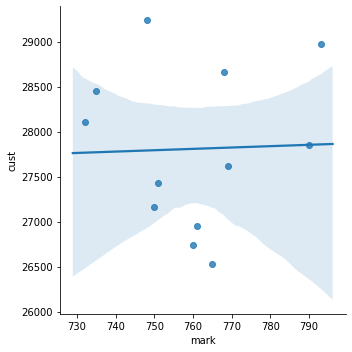

In [226]:
X = charthouse[['mark']]
y = charthouse[['cust']]
sns.lmplot(data=charthouse, x='mark', y='cust')